# 시간+공휴일여부+날씨 만 가지고 클러스터링

* 대여량(종속변수, 타겟)은 클러스터링에 사용 안 함  
* 클러스터링에 사용할 설명 변수 예시:
  - 시간대그룹 (출퇴근 여부 등 범주형)
  - 계절, 공휴일 여부, 정상운영일 여부 등 (범주형)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set(style="whitegrid")


# data import

# 파일 경로에 맞게 수정하세요
file_path = 'SeoulBikeData_전처리.csv'

# CSV 파일 불러오기 (인코딩 문제 시 encoding='utf-8' 또는 'cp949' 조정)
data = pd.read_csv(file_path, encoding='utf-8')

# 데이터 일부 확인
print(data.head())

# 한글 폰트 설정 코드 (Matplotlib용)
# Matplotlib 시각화 할 때 한글 폰트 제대로 지원하도록 설정하는 코드입니다.
# 수정하지 마세용.
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

def set_korean_font():
    system_name = platform.system()
    if system_name == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
    elif system_name == 'Darwin':  # macOS
        # macOS 기본 한글 폰트 예: AppleGothic
        font_path = '/System/Library/Fonts/AppleGothic.ttf'
    else:  # Linux
        # 대표적인 한글 폰트 경로 (예: 나눔고딕)
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    
    try:
        font_name = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font_name)
        print(f"{system_name}에서 '{font_name}' 폰트를 설정했습니다.")
    except Exception as e:
        print(f"폰트 설정에 실패했습니다: {e}")
        print("시스템 기본 폰트를 사용합니다.")
    
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

set_korean_font()

           날짜  대여량  시간  기온(°C)  습도(%)  풍속(m/s)  가시거리(10m)  이슬점 온도(°C)  \
0  01/12/2017  254   0    -5.2     37      2.2       2000       -17.6   
1  01/12/2017  204   1    -5.5     38      0.8       2000       -17.6   
2  01/12/2017  173   2    -6.0     39      1.0       2000       -17.7   
3  01/12/2017  107   3    -6.2     40      0.9       2000       -17.6   
4  01/12/2017   78   4    -6.0     36      2.3       2000       -18.6   

   일사량(MJ/m2)  강수량(mm)  적설(cm)      계절      공휴일 여부 정상운영일 여부  시간대  
0         0.0      0.0     0.0  Winter  No Holiday      Yes    1  
1         0.0      0.0     0.0  Winter  No Holiday      Yes    1  
2         0.0      0.0     0.0  Winter  No Holiday      Yes    1  
3         0.0      0.0     0.0  Winter  No Holiday      Yes    1  
4         0.0      0.0     0.0  Winter  No Holiday      Yes    2  
Windows에서 'Malgun Gothic' 폰트를 설정했습니다.


In [2]:
# 시간대그룹 생성 함수
# 기준은 수빈님이 세우신 거 따라갑니다.
def 시간대그룹(hour):
    if hour in [7, 8, 18, 19]:
        return 0                 # 그룹 0이 출퇴근 시간대입니다.
    elif hour in [0, 1, 2, 3]:
        return 1
    elif hour in [4, 5, 6, 9]:
        return 2
    elif hour in [10, 11, 12, 13]:
        return 3
    elif hour in [14, 15, 16, 17]:
        return 4
    else:  # 20, 21, 22, 23
        return 5

# 적용
data['시간대그룹'] = data['시간'].apply(시간대그룹)

In [27]:
# 1. 사용할 변수 목록 정의
# python은 한글로도 변수 선언할 수 있슴다.
# 날씨/시간/환경처럼 구분해 놓은 걸 따로 처리해야하는가?
# 아니요!
# 클러스터링에서는 그런 구분은 분석적 구상(머릿속 정리)을 위한 것이고, 실제로 모델에 넣을 때는 그냥 한꺼번에 다 넣으면 된다고 합니다.


설명변수목록 = ['계절', '공휴일 여부', '정상운영일 여부', '시간대그룹']

data_encoded = pd.get_dummies(data[설명변수목록], drop_first=True)

print(data_encoded)

      시간대그룹  계절_Spring  계절_Summer  계절_Winter  공휴일 여부_No Holiday  정상운영일 여부_Yes
0         1      False      False       True               True          True
1         1      False      False       True               True          True
2         1      False      False       True               True          True
3         1      False      False       True               True          True
4         2      False      False       True               True          True
...     ...        ...        ...        ...                ...           ...
8755      0      False      False      False               True          True
8756      5      False      False      False               True          True
8757      5      False      False      False               True          True
8758      5      False      False      False               True          True
8759      5      False      False      False               True          True

[8760 rows x 6 columns]


# 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler

# 변수 스케일링 (표준화)
# 거리 기반 알고리즘(KMeans)은 변수 단위가 다르면 안 됨
# 예: 기온: -5~30 / 습도: 0~100 → 범위 맞춰야 함

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded)


8760


# 클러스터링 시도.

In [ ]:
from sklearn.cluster import KMeans

# 클러스터링 시도. n_clusters parameter로 클러스터 군집 개수 지정
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 클러스터링 결과를 data table에 삽입
data['클러스터'] = clusters

8760

# 클러스터링 군집 개수 정하기.

# 해석
- Elbow 방법을 사용한 결과를 보면 k=5,6 근처에서 완만하고, 10 이후부터 완만해집니다.
- 실루엣 방법을 사용한 결과를 보면 실 k=10 이후가가장 좋은 점수를 가지고 있으나, 클러스터 개수가 많아질 수록 해석 및 결론을 내리기에 굉장히 어려워지기에, 보통 3~6개로 선정을 하는 편입니다.
  - 따라서 모든 설명변수를 기준으로 k-means를 구한 결과처럼 k=6, 즉 클러스터를 6개로 만드는 편이 좋아보입니다.

따라서 k=6를 기준으로 클러스터링을 시도하겠습니다.

# 클러스터링 군집 개수 정하기.
## 엘보우(Elbow) 방법

우선 가장 익숙한 거리 제곱합으로 해석해보기위해 선정했습니다.  
아이디어: k를 늘리면서 클러스터 내 거리 제곱합(SSE, inertia)이 급격히 줄다가 완만해지는 지점(팔꿈치 모양)을 찾는 방법입니다.  
클러스터 수 증가에 따른 SSE(오차 제곱합)를 그래프로 그려서 ‘팔꿈치’ 지점에서 k를 선택

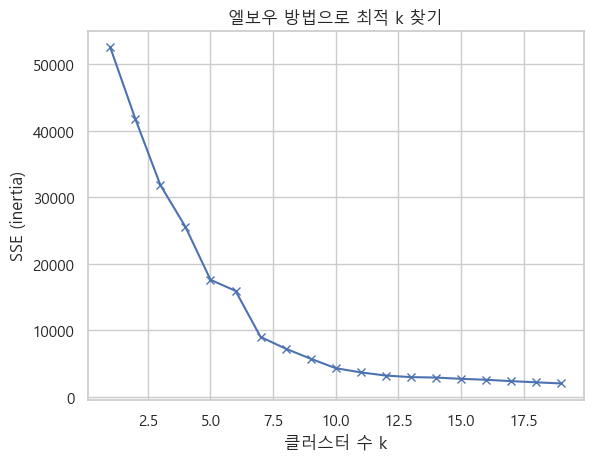

In [15]:
# 클러스터링 군집 개수 정하기...

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('클러스터 수 k')
plt.ylabel('SSE (inertia)')
plt.title('엘보우 방법으로 최적 k 찾기')
plt.show()

# 클러스터링 군집 개수 정하기
## 2번째 방식
### 실루엣 점수(Silhouette Score)
각 데이터가 자기 클러스터에 얼마나 잘 맞는지 평가  

-1 ~ 1 사이 점수, 1에 가까울수록 좋은 클러스터링  

여러 k에 대해 계산 후 최고 점수를 주는 k 선택  

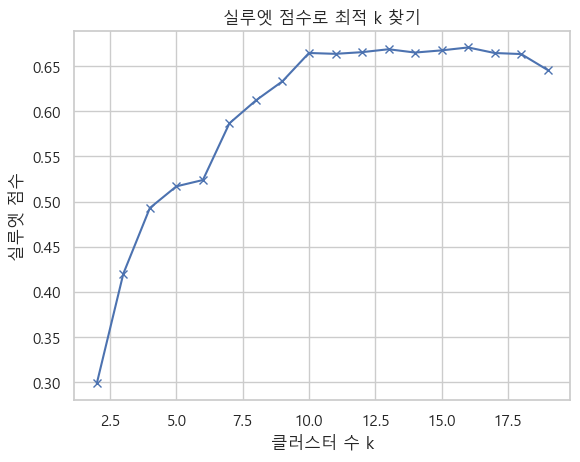

In [16]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.plot(K, sil_scores, 'bx-')
plt.xlabel('클러스터 수 k')
plt.ylabel('실루엣 점수')
plt.title('실루엣 점수로 최적 k 찾기')
plt.show()

# 클러스터링 결과를 2D로 시각화 (PCA)
클러스터링이 잘 나뉘었는지 보기 위한 시각화.
고차원 데이터를 2차원으로 줄여서 표현해주는 방식.

# 해석
k=6로 클러스터링 시도했을 때, 클러스터 5가 모여있지 않은 것처럼 나와서 어떻게 해석해야할 지 고민중이다.

C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_11424\2405142241.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='클러스터')


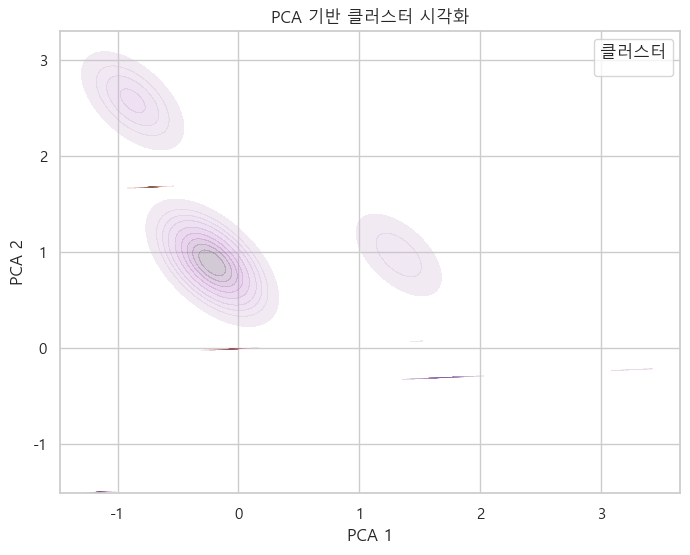

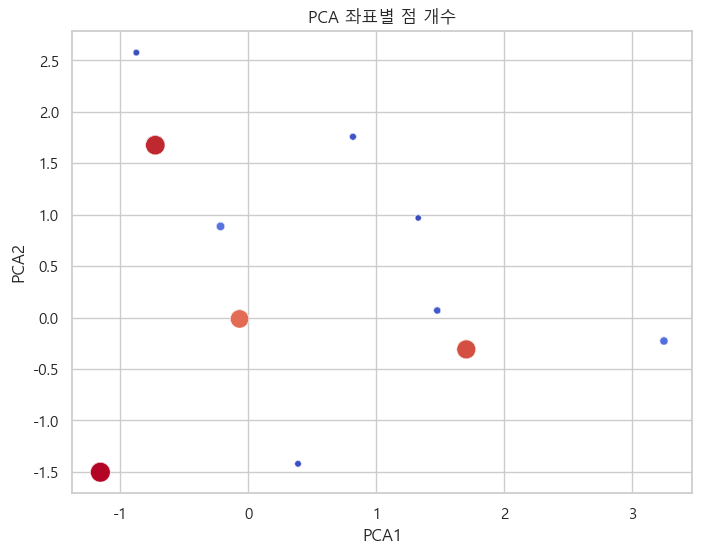

PCA1    66
PCA2    66
클러스터     6
dtype: int64
PCA1       PCA2     
-1.155624  -1.500132    360
-1.155510  -1.500897    360
-1.155395  -1.501661    360
-1.155280  -1.502425    360
-1.155165  -1.503189    360
                       ... 
 3.247392  -0.224749     32
 3.247507  -0.225513     32
 3.247622  -0.226277     32
 3.247736  -0.227042     32
 3.247851  -0.227806     32
Length: 66, dtype: int64


In [ ]:
# 구조 시각화
# PCA로 차원 축소 후 클러스터링 결과 시각화
from sklearn.decomposition import PCA

# PCA로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA 결과를 DataFrame으로 변환
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# 클러스터 정보 붙이기 (인덱스 맞춰서)
pca_df['클러스터'] = data['클러스터'].values

# 시각화 1 -> 잘 안보임
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='클러스터',
    fill=True,
    common_norm=False,
    alpha=0.3
)

plt.title('PCA 기반 클러스터 시각화')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='클러스터')
plt.show()

# 시각화 2 -> 점의 개수에 따라 크기를 다르게
df_count = pca_df.groupby(['PCA1', 'PCA2']).size().reset_index(name='count')

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_count, x='PCA1', y='PCA2', size='count', hue='count',
                palette='coolwarm', sizes=(20, 200), legend=False)
plt.title('PCA 좌표별 점 개수')
plt.show()



print(pca_df.nunique())  # 각 열에서 고유값 몇 개인지
print()
print(pca_df.groupby(['PCA1', 'PCA2']).size().sort_values(ascending=False).head(10))





# 클러스터 해석 요약표 생성
각 클러스터가 어떤 의미를 가지는 지 의미부여하기.(논의가 필요한 부분)

k=6 기준

- cluster 0
  -  
- cluster 1
  -  
- cluster 2
  -  
- cluster 3
  -  
- cluster 4
  -  
- cluster 5
  -  

In [18]:
import pandas as pd

# 클러스터와 범주형 변수
cat_vars = ['시간대그룹', '계절', '공휴일 여부']  # 범주형 변수만 사용한 경우
cluster_cat_props = {}

# 각 범주형 변수에 대해 클러스터별 비율 계산
for var in cat_vars:
    # 각 클러스터에서 해당 범주의 비율 (row: 클러스터, col: 범주값)
    temp = data.groupby('클러스터')[var].value_counts(normalize=True).unstack().fillna(0)
    cluster_cat_props[var] = temp.applymap(lambda x: f'{round(x*100)}%')

# 최종 요약표 생성
summary_table = pd.DataFrame()

for var in cat_vars:
    # 가장 비율이 높은 항목과 그 퍼센트
    top_value = cluster_cat_props[var].idxmax(axis=1)
    top_percent = cluster_cat_props[var].max(axis=1)
    summary_table[var + '_주요값'] = top_value.astype(str) + ' (' + top_percent.astype(str) + ')'

# 특이점 요약 칸 (사람이 해석할 수 있게 비워둠)
summary_table['요약해석'] = ['' for _ in range(len(summary_table))]

# 클러스터 번호 열 정리
summary_table.reset_index(inplace=True)
summary_table.columns.name = None

# 출력
summary_table


C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_11424\312149016.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_cat_props[var] = temp.applymap(lambda x: f'{round(x*100)}%')
C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_11424\312149016.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_cat_props[var] = temp.applymap(lambda x: f'{round(x*100)}%')
C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_11424\312149016.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_cat_props[var] = temp.applymap(lambda x: f'{round(x*100)}%')


,클러스터,시간대그룹_주요값,계절_주요값,공휴일 여부_주요값,요약해석
0,0,0 (17%),Spring (100%),No Holiday (97%),
1,1,0 (17%),Autumn (100%),No Holiday (95%),
2,2,0 (33%),Winter (100%),No Holiday (91%),
3,3,0 (17%),Summer (100%),No Holiday (98%),
4,4,1 (18%),Autumn (84%),No Holiday (92%),
5,5,3 (33%),Winter (100%),No Holiday (91%),


# 클러스터 별 분석 시작

C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_11424\4061702360.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='클러스터', y='대여량', data=data, ci=None, ax=axes[0])


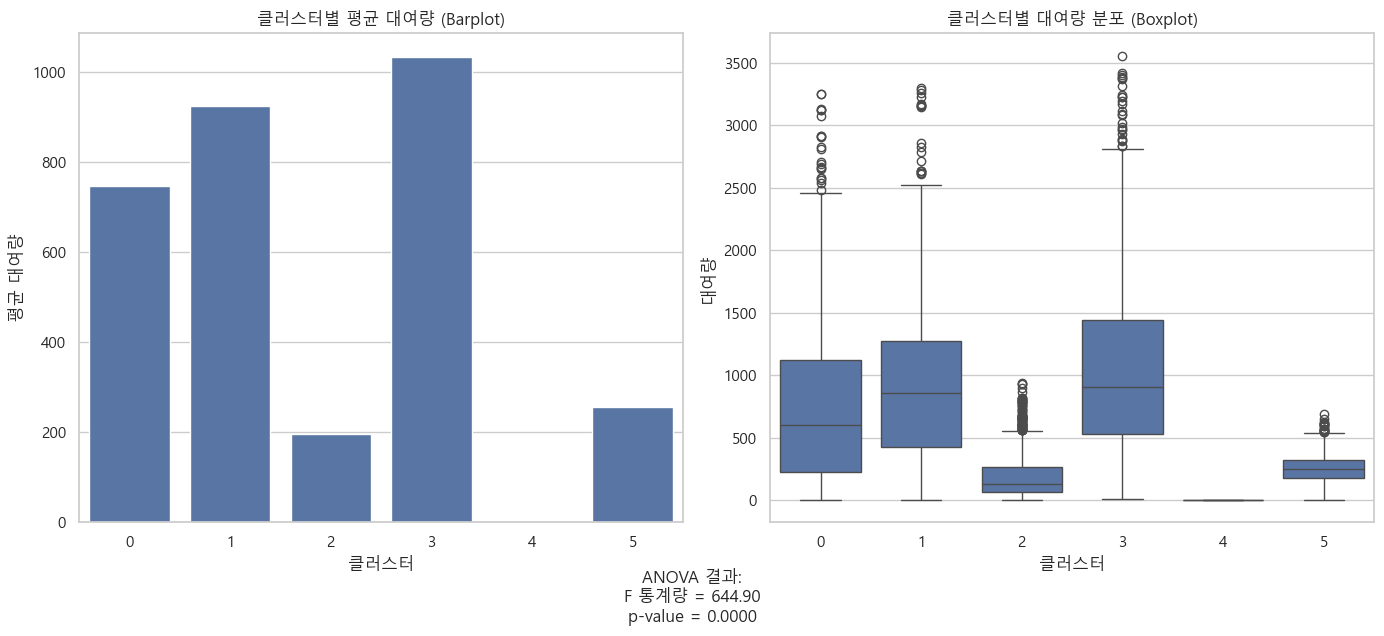

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# 클러스터별 대여량 그룹 나누기 (ANOVA용)
groups = [group['대여량'].values for name, group in data.groupby('클러스터')]
f_stat, p_val = f_oneway(*groups)

# 시각화 시작
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # barplot + boxplot 가로로 2개

# (1) Barplot: 클러스터별 평균 대여량
sns.barplot(x='클러스터', y='대여량', data=data, ci=None, ax=axes[0])
axes[0].set_title('클러스터별 평균 대여량 (Barplot)')
axes[0].set_xlabel('클러스터')
axes[0].set_ylabel('평균 대여량')

# (2) Boxplot: 클러스터별 대여량 분포
sns.boxplot(x='클러스터', y='대여량', data=data, ax=axes[1])
axes[1].set_title('클러스터별 대여량 분포 (Boxplot)')
axes[1].set_xlabel('클러스터')
axes[1].set_ylabel('대여량')

# (3) ANOVA 결과를 텍스트로 추가 (전체 figure에 표시)
anova_text = f'ANOVA 결과:\nF 통계량 = {f_stat:.2f}\np-value = {p_val:.4f}'
plt.figtext(0.5, -0.05, anova_text, ha='center', fontsize=12)

plt.tight_layout()
plt.show()


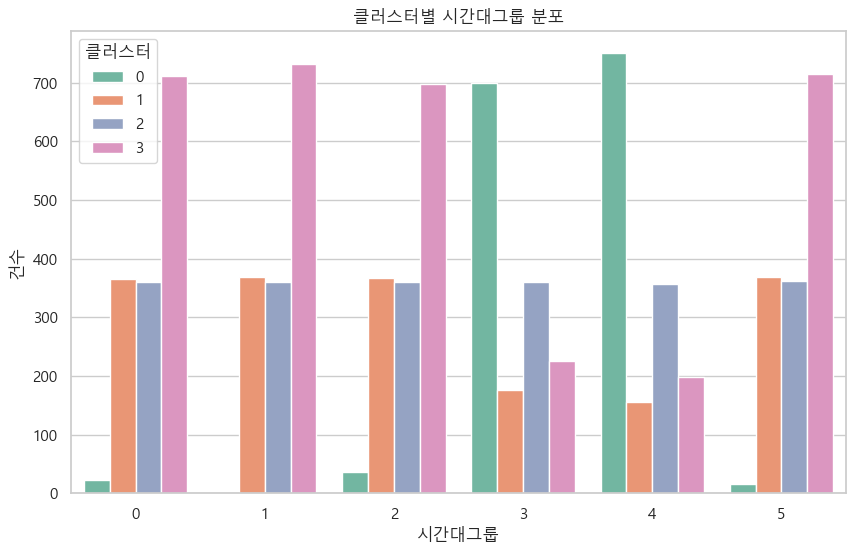

In [ ]:
# 클러스터별 시간대그룹 분포 (Countplot)

plt.figure(figsize=(10, 6))
sns.countplot(x='시간대그룹', hue='클러스터', data=data, palette='Set2')
plt.title('클러스터별 시간대그룹 분포')
plt.xlabel('시간대그룹')
plt.ylabel('건수')
plt.legend(title='클러스터')
plt.show()

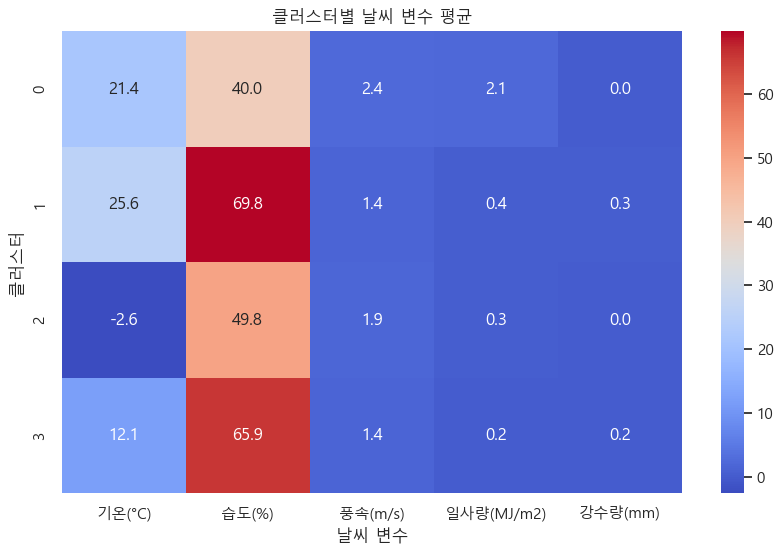

In [22]:
# 클러스터별 날씨 변수 평균 (Heatmap)
# 날씨 관련 변수 목록
weather_vars = ['기온(°C)', '습도(%)', '풍속(m/s)', '일사량(MJ/m2)', '강수량(mm)']

# 클러스터별 평균 계산
cluster_weather_mean = data.groupby('클러스터')[weather_vars].mean()

# 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_weather_mean, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('클러스터별 날씨 변수 평균')
plt.xlabel('날씨 변수')
plt.ylabel('클러스터')
plt.show()

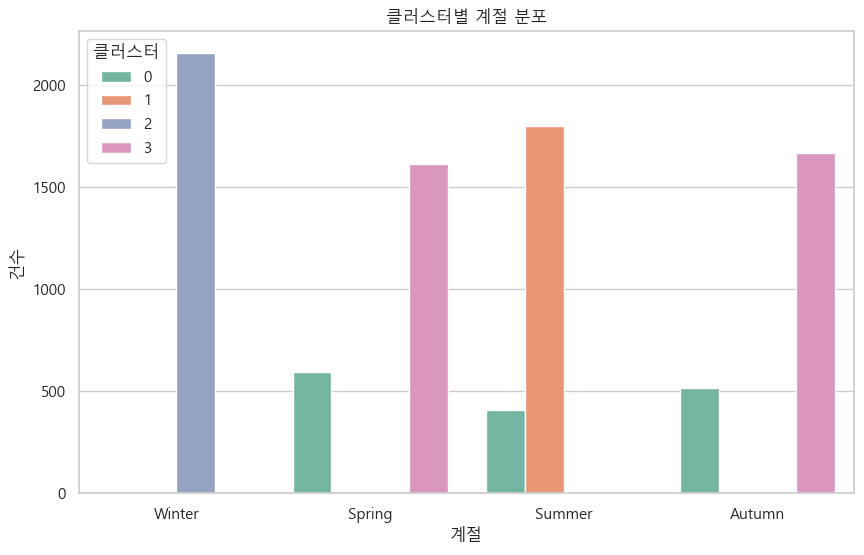

In [23]:
# 클러스터별 범주형 변수 비율 (계절)
plt.figure(figsize=(10, 6))
sns.countplot(x='계절', hue='클러스터', data=data, palette='Set2')
plt.title('클러스터별 계절 분포')
plt.xlabel('계절')
plt.ylabel('건수')
plt.legend(title='클러스터')
plt.show()

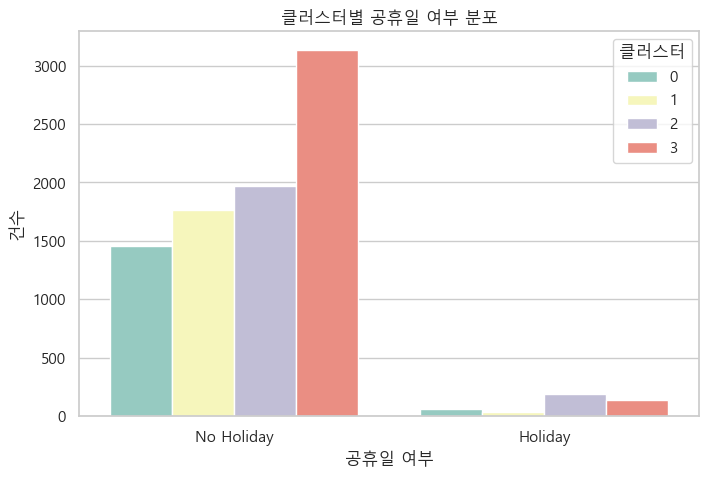

In [24]:
# 클러스터별 범주형 변수 비율 (공휴일 여부)

plt.figure(figsize=(8, 5))
sns.countplot(x='공휴일 여부', hue='클러스터', data=data, palette='Set3')
plt.title('클러스터별 공휴일 여부 분포')
plt.xlabel('공휴일 여부')
plt.ylabel('건수')
plt.legend(title='클러스터')
plt.show()

C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_18572\3721537082.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='클러스터', y=var, data=data, palette='Set2')
C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_18572\3721537082.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='클러스터', y=var, data=data, palette='Set2')
C:\Users\HyoDae Kim\AppData\Local\Temp\ipykernel_18572\3721537082.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='클러스터', y=var, data=data, palette='Set2')


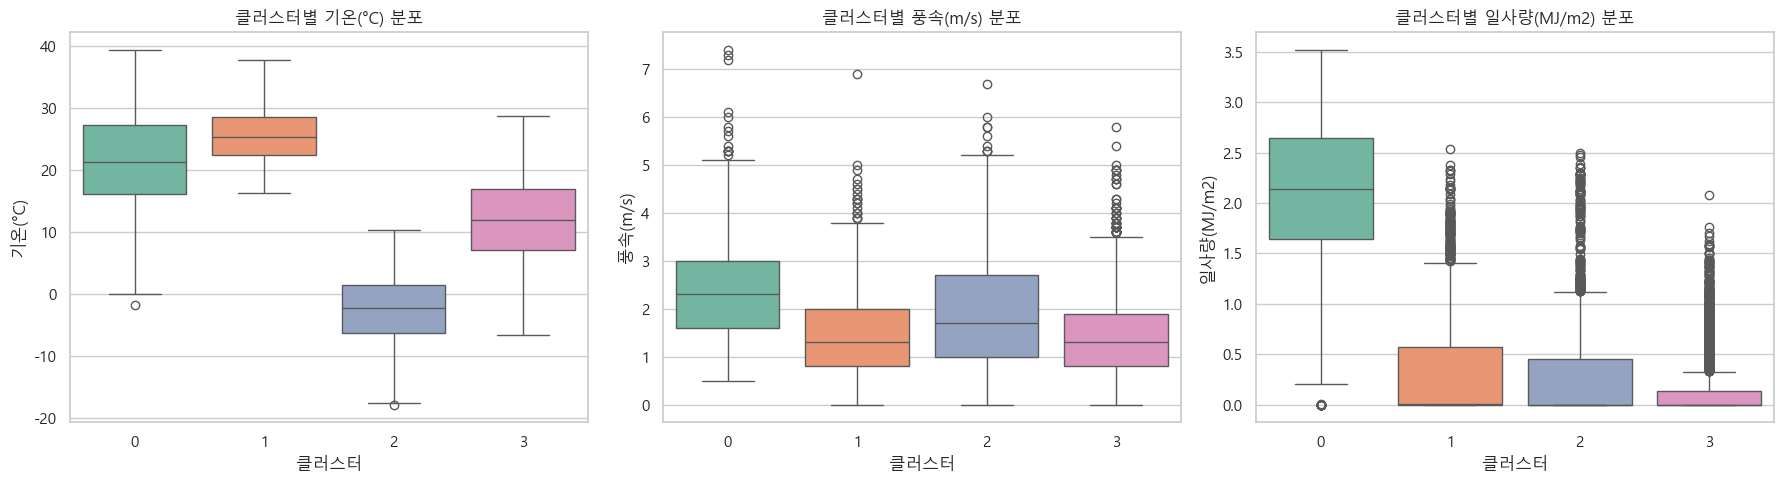

In [25]:
# 클러스터별 연속형 변수 Boxplot 시각화

import seaborn as sns
import matplotlib.pyplot as plt

# 비교할 연속형 변수 목록
num_vars = ['기온(°C)', '풍속(m/s)', '일사량(MJ/m2)']

# 시각화
plt.figure(figsize=(18, 5))  # 가로로 나란히 3개

for i, var in enumerate(num_vars):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='클러스터', y=var, data=data, palette='Set2')
    plt.title(f'클러스터별 {var} 분포')
    plt.xlabel('클러스터')
    plt.ylabel(var)

plt.tight_layout()
plt.show()